In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from matplotlib import cm

In [8]:
class PricingEnvironment:
    def __init__(self, cost, prices, distribution="truncnorm", **dist_params):
        self.cost = cost
        self.prices = np.array(prices)

        # Build the valuation distribution object
        self.v_t = self._create_distribution(distribution, dist_params)

    def _create_distribution(self, distribution, params):
        """Factory to create the valuation distribution."""
        if distribution == "truncnorm":
            mean = params.get("mean", 0.6)
            std = params.get("std", 0.4)
            lower = params.get("lower", 0)
            upper = params.get("upper", 1)
            a, b = (lower - mean) / std, (upper - mean) / std
            return stats.truncnorm(a, b, loc=mean, scale=std)
        
        elif distribution == "uniform":
            low = params.get("low", 0)
            high = params.get("high", 1)
            return stats.uniform(loc=low, scale=high-low)
        
        elif distribution == "beta":
            a = params.get("a", 2)
            b = params.get("b", 5)
            return stats.beta(a, b)
        
        elif distribution == "expon":
            scale = params.get("scale", 1.0)
            return stats.expon(scale=scale)
        
        elif distribution == "normal":
            loc = params.get("loc", 0.5)
            scale = params.get("scale", 0.1)
            return stats.norm(loc=loc, scale=scale)
        
        else:
            raise ValueError(f"Unsupported distribution: {distribution}")

    def round(self, p_t, n_t):
        """Simulate a single round given price p_t and number of customers n_t."""
        conversion_prob = self.conversion_probability(p_t)
        d_t = np.random.binomial(n_t, conversion_prob)
        r_t = (p_t - self.cost) * d_t
        return d_t, r_t
    
    def conversion_probability(self, price):
        """Probability that a random customer valuation exceeds the price."""
        return 1 - self.v_t.cdf(price)

In [9]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

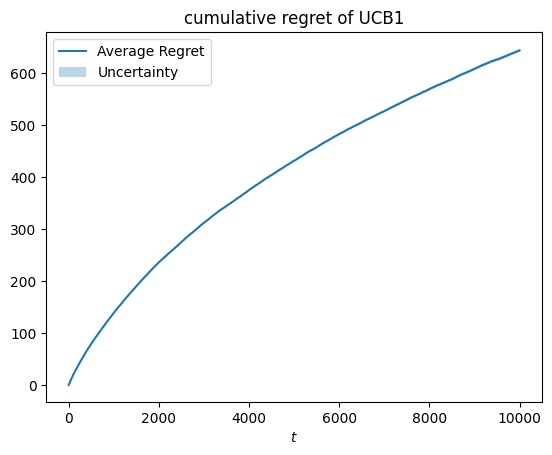

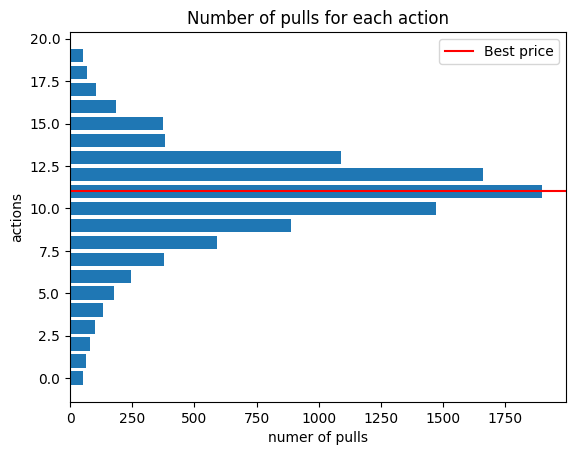

In [11]:
T = 10000
epsilon = T**(-0.33)
K = int(1/epsilon)
min_price, max_price = 0, 1
n_customers = 1
cost = 0
prices = np.linspace(min_price, max_price, K) 
reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer


n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    ucb_agent = UCB1Agent(K, T, range=1)

    np.random.seed(seed)
    #env = PricingEnvironment(cost=cost, prices=prices, distribution="uniform", low=0, high=1)
    env = PricingEnvironment(cost=cost, prices=prices, distribution="truncnorm",mean=0.8, std=0.2, lower=0, upper=1)

    many_prices = np.linspace(min_price, max_price, K)
    profit_curve = reward_function(many_prices, n_customers*env.conversion_probability(many_prices))
    best_price_index = np.argmax(profit_curve)
    best_price = many_prices[best_price_index]
    expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        d_t, r_t = env.round(p_t, n_customers)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(K), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();